In [8]:
import sys
sys.executable


'c:\\dev\\aiops-logs-anomaly\\.venv\\Scripts\\python.exe'

In [38]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense



In [11]:
df = pd.read_csv("../data/raw/hdfs/HDFS_2k.log_structured.csv")
df.head()


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,E10,PacketResponder <*> for block blk_<*> terminating
1,2,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,E10,PacketResponder <*> for block blk_<*> terminating
2,3,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,E10,PacketResponder <*> for block blk_<*> terminating
4,5,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,E10,PacketResponder <*> for block blk_<*> terminating


In [12]:
df.columns



Index(['LineId', 'Date', 'Time', 'Pid', 'Level', 'Component', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')

In [ ]:
df = df[["LineId", "EventId", "EventTemplate"]]
df.head()


,LineId,EventId,EventTemplate
0,1,E10,PacketResponder <*> for block blk_<*> terminating
1,2,E10,PacketResponder <*> for block blk_<*> terminating
2,3,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,E10,PacketResponder <*> for block blk_<*> terminating
4,5,E10,PacketResponder <*> for block blk_<*> terminating


In [13]:
WINDOW_SIZE = 20

sequences = []
for i in range(len(df) - WINDOW_SIZE + 1):
    seq = df["EventId"].iloc[i:i+WINDOW_SIZE].tolist()
    sequences.append(seq)

len(sequences)


1981

In [14]:
import numpy as np
from collections import Counter

all_events = sorted({e for seq in sequences for e in seq})
event_index = {e: i for i, e in enumerate(all_events)}
NUM_EVENTS = len(all_events)

NUM_EVENTS



14

In [15]:
def to_count_vector(seq):
    vec = np.zeros(NUM_EVENTS)
    counts = Counter(seq)
    for e, c in counts.items():
        vec[event_index[e]] = c
    return vec

X_if = np.vstack([to_count_vector(seq) for seq in sequences])
X_if.shape



(1981, 14)

In [16]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

iforest.fit(X_if)

if_scores = -iforest.decision_function(X_if)
threshold = np.percentile(if_scores, 95)
y_if = (if_scores > threshold).astype(int)

np.unique(y_if, return_counts=True)



(array([0, 1]), array([1882,   99]))

In [17]:
# Convert EventId strings → integer indices
encoded_sequences = [
    [event_index[e] for e in seq]
    for seq in sequences
]

# sanity check
encoded_sequences[0][:10]

from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = WINDOW_SIZE

X_seq = pad_sequences(
    encoded_sequences,
    maxlen=MAX_LEN,
    padding="post"
)

X_seq.shape



(1981, 20)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=NUM_EVENTS + 1, output_dim=32, mask_zero=True),
    LSTM(64),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(
    X_seq,
    np.zeros(len(X_seq)),
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2237 - val_loss: 0.0017
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 3.8034e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6554e-04 - val_loss: 2.5515e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9065e-04 - val_loss: 2.0071e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8917e-04 - val_loss: 1.6566e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1838e-04 - val_loss: 1.3908e-04
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6146e-04 - val_loss: 1.2001e-04
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2156e-04 - val_loss: 1.0500e-04
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8857e-04 - val_loss: 9.3395e-05
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6325e-04 - val_loss: 8.4090e-05


In [20]:
import numpy as np

y_dummy = np.zeros(len(X_seq))  # self-supervised (all normal)

history = model.fit(
    X_seq,
    y_dummy,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4319e-04 - val_loss: 7.6103e-05
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2618e-04 - val_loss: 6.9726e-05
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1371e-04 - val_loss: 6.3516e-05
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0085e-04 - val_loss: 5.8669e-05
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1592e-05 - val_loss: 5.4260e-05
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2871e-05 - val_loss: 5.0612e-05
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6099e-05 - val_loss: 4.7113e-05
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9664e-05 - val_loss: 4.4059e-05
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4385e-05 - val_loss: 4.1202e-05
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9325e-05 - val_loss: 3.8691e-05


In [21]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 32)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,133 (297.40 KB)

 Trainable params: 25,377 (99.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,756 (198.27 KB)

In [23]:
lstm_scores = model.predict(X_seq).flatten()

lstm_scores[:10], lstm_scores.min(), lstm_scores.max()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(array([3.8466635e-05, 3.8286504e-05, 3.8107140e-05, 3.8087666e-05,
        3.8241182e-05, 3.8104703e-05, 3.8222588e-05, 3.8262708e-05,
        4.0774645e-05, 4.3780234e-05], dtype=float32),
 np.float32(3.667474e-05),
 np.float32(0.007075778))

In [24]:
threshold = np.percentile(lstm_scores, 95)
threshold


np.float32(4.080631e-05)

In [25]:
y_lstm = (lstm_scores > threshold).astype(int)
np.unique(y_lstm, return_counts=True)


(array([0, 1]), array([1882,   99]))

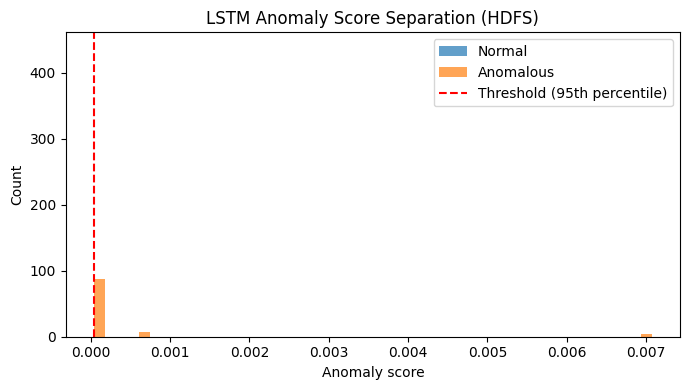

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(lstm_scores[y_lstm == 0], bins=50, alpha=0.7, label="Normal")
plt.hist(lstm_scores[y_lstm == 1], bins=50, alpha=0.7, label="Anomalous")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold (95th percentile)")
plt.xlabel("Anomaly score")
plt.ylabel("Count")
plt.title("LSTM Anomaly Score Separation (HDFS)")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
lstm_anomaly_scores = 1.0 - lstm_scores

ratios = [0.25, 0.5, 0.75]
mean_scores = []

for r in ratios:
    X_pref = pad_sequences(
        [seq[:max(1, int(len(seq)*r))] for seq in encoded_sequences],
        maxlen=MAX_LEN,
        padding="post"
    )
    scores = 1.0 - model.predict(X_pref).flatten()
    mean_scores.append(scores.mean())
    print(f"{int(r*100)}% observed → mean anomaly score = {scores.mean():.6f}")



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
25% observed → mean anomaly score = 0.992713
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
50% observed → mean anomaly score = 0.998333
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
75% observed → mean anomaly score = 0.999420


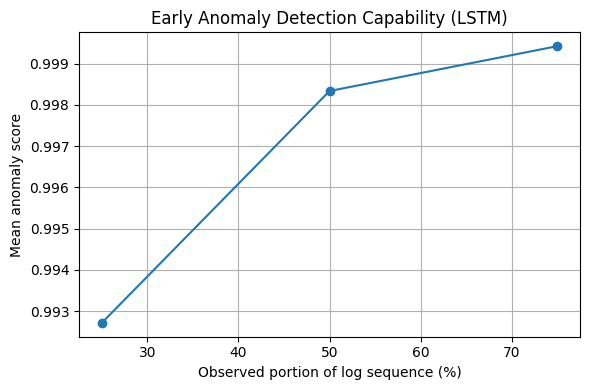

In [32]:
plt.figure(figsize=(6,4))
plt.plot([25, 50, 75], mean_scores, marker="o")
plt.xlabel("Observed portion of log sequence (%)")
plt.ylabel("Mean anomaly score")
plt.title("Early Anomaly Detection Capability (LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
anomalous_indices = np.where(y_lstm == 1)[0]

ratios = [0.25, 0.5, 0.75]
mean_scores = []

for r in ratios:
    X_pref = pad_sequences(
        [encoded_sequences[i][:max(1, int(len(encoded_sequences[i])*r))]
         for i in anomalous_indices],
        maxlen=MAX_LEN,
        padding="post"
    )
    scores = 1.0 - model.predict(X_pref).flatten()
    mean_scores.append(scores.mean())
    print(f"{int(r*100)}% observed → mean anomaly score = {scores.mean():.6f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
25% observed → mean anomaly score = 0.938508
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50% observed → mean anomaly score = 0.968094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
75% observed → mean anomaly score = 0.989156


In [34]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

iforest.fit(X_if)
if_scores = -iforest.decision_function(X_if)

if_threshold = np.percentile(if_scores, 95)
y_if = (if_scores > if_threshold).astype(int)

np.unique(y_if, return_counts=True)


(array([0, 1]), array([1882,   99]))

In [35]:
import pandas as pd

comparison = pd.DataFrame({
    "LSTM": y_lstm,
    "IsolationForest": y_if
})

comparison.value_counts()


LSTM  IsolationForest
0     0                  1794
      1                    88
1     0                    88
      1                    11
Name: count, dtype: int64

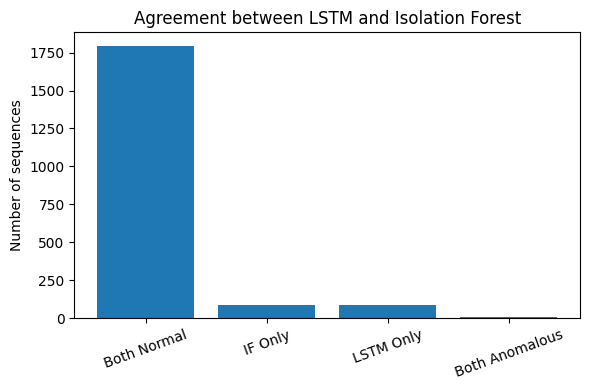

In [36]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Both Normal", "IF Only", "LSTM Only", "Both Anomalous"]
values = [1794, 88, 88, 11]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Number of sequences")
plt.title("Agreement between LSTM and Isolation Forest")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [37]:
intersection = np.sum((y_lstm == 1) & (y_if == 1))
union = np.sum((y_lstm == 1) | (y_if == 1))

jaccard = intersection / union
jaccard


np.float64(0.058823529411764705)